<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/11/PTE_DL11_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 11. gyakorlat: word2vec
### 2022. november 23.

##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Szóbeágyazások és érzelmek felismerése

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c04_nlp_embeddings_and_sentiment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c04_nlp_embeddings_and_sentiment.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Ebben a munkafüzetben szóbeágyazásokkal fogsz dolgozni, és egy alap neurális hálózatot fogsz betanítani a szövegek hangulatának előrejelzésére. A végén képes leszel vizualizálni, hogy a hálózat hogyan látja az adathalmaz egyes szavainak kapcsolódó hangulatát.

## TensorFlow és kapcsolódó függvények importálása

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Adatok letöltése

Egy olyan adathalmazt fogunk használni, amely az Amazon és a Yelp értékeléseit tartalmazza, a hozzájuk tartozó érzelmekkel (1 a pozitív, 0 a negatív). Ez az adatkészlet eredetileg [itt](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set) forrásból származik.

In [3]:
!wget --no-check-certificate \
    -O sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2022-11-23 13:29:22--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.101, 74.125.195.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bd2p0cvedtpe2g6gde8ehmq35e9fd00e/1669210125000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=5fdbcfef-66c9-494d-afa9-1d2b7e989c20 [following]
--2022-11-23 13:29:22--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bd2p0cvedtpe2g6gde8ehmq35e9fd00e/1669210125000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=5fdbcfef-66c9-494d-afa9-1d2b7e989c20
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-08

In [4]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenizáljuk az adathalmazt

Tokenizáljuk az adathalmazt, beleértve a kitöltést és az OOV-ot is. (OOV szótáron kívüli szavak)

In [5]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

## Szekvencia áttekintése

Vessünk egy gyors pillantást az egyik kitöltött szekvenciára, hogy megbizonyosodjunk arról, hogy a fentiekben minden megfelelően működött.

In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

good case excellent value ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Good case Excellent value.


## Alapszintű modell képzése beágyazásokkal

In [7]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 6)                 9606      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
50/50 [==============================] - 5s 16ms/step - loss: 0.6930 - accuracy: 0.5185 - val_loss: 0.6944 - val_accuracy: 0.4211
Epoch 2/10
50/50 [==============================] - 0s 8ms/step - loss: 0.6815 - accuracy: 0.5386 - val_loss: 0.6901 - val_accuracy: 0.5113
Epoch 3/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6508 - accuracy: 0.6309 - val_loss: 0.6648 - val_accuracy: 0.6642
Epoch 4/10
50/50 [==============================] - 0s 6ms/step - loss: 0.5722 - accuracy: 0.7960 - val_loss: 0.6197 - val_accuracy: 0.6767
Epoch 5/10
50/50 [==============================] - 0s 8ms/step - loss: 0.4531 - accuracy: 0.8883 - val_loss: 0.5522 - val_accuracy: 0.7318
Epoch 6/10
50/50 [==============================] - 0s 8ms/step - loss: 0.3530 - accuracy: 0.9027 - val_loss: 0.5560 - val_accuracy: 0.7218
Epoch 7/10
50/50 [==============================] - 0s 8ms/step - loss: 0.2744 - accuracy: 0.9291 - val_loss: 0.4807 - val_accuracy: 0.7594
Epoch 8/10
50/50 [=

## A képzési adatok vizualizálása

Az alábbiakban ismét megjeleníthetjük a képzési grafikont. Látszik-e különbség a validálási pontosság és veszteség tendenciájában a teljes szavakkal való összehasonlításhoz képest?

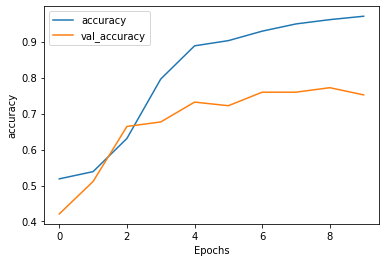

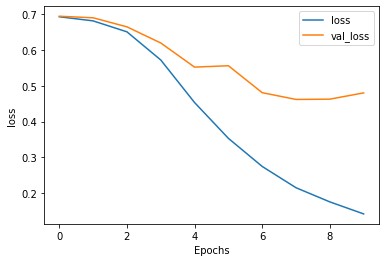

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## A hálózat vizualizálásához szükséges fájlok letöltése

Az alábbi kód két fájlt tölt le annak vizualizálásához, hogy a hálózatod hogyan "látja" az egyes szavakhoz kapcsolódó érzelmeket. Menj a http://projector.tensorflow.org/ oldalra, és töltsd be ezeket a fájlokat, majd kattints a "Sphereize" jelölőnégyzetre.

In [10]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [11]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [12]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Az új vélemények hangulatának előrejelzése

Most, hogy a hálózatot betanítottuk és vizualizáltuk, nézzük meg az alábbiakban, hogyan tudjuk megjósolni az új vélemények hangulatát, amelyeket a hálózat még soha nem látott.

In [13]:
# Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nFRISSEN A NYOMDÁBÓL! ITT VAN NÉHÁNY ÚJONNAN KÉSZÜLT, TELJESEN HITELES VÉLEMÉNY!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

FRISSEN A NYOMDÁBÓL! ITT VAN NÉHÁNY ÚJONNAN KÉSZÜLT, TELJESEN HITELES VÉLEMÉNY!

1/1 [==============================] - 0s 68ms/step
I love this phone
[0.9910382]


I hate spaghetti
[0.06495552]


Everything was cold
[0.37686792]


Everything was hot exactly as I wanted
[0.82304317]


Everything was green
[0.49346972]


the host seated us immediately
[0.8194919]


they gave us free chocolate cake
[0.9095962]


not sure about the wilted flowers on the table
[0.06974527]


only works when I stand on tippy toes
[0.9584969]


does not work when I stand on my head
[0.01663883]


